# Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import requests, zipfile, os
import io

import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Load Data

In [2]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [3]:
df = pd.DataFrame({
    'Text': newsgroups.data,
    'Category': newsgroups.target
})
df['Category Name'] = df['Category'].apply(lambda x: newsgroups.target_names[x])
df

,Text,Category,Category Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics


# Preprocessing

In [4]:
# Lowercasing
df['Text'] = df['Text'].str.lower()

# Remove Punctuation and special characters
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenization
df['Tokens'] = df['Text'].apply(word_tokenize)

# Removing Stopwords
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

#Lemmatization
lemmatizer = WordNetLemmatizer()
df['Tokens'] = df['Tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Download GloVe Embeddings

In [5]:
# Directory where we'll save the embeddings
glove_dir = "/kaggle/working/glove_embeddings"
os.makedirs(glove_dir, exist_ok=True)

# Download GloVe embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
response = requests.get(glove_url)

# Extract GloVe embeddings from the zip file to /kaggle/working/
with zipfile.ZipFile(io.BytesIO(response.content)) as glove_zip:
    glove_zip.extractall(glove_dir)

In [6]:
glove_dir = "/kaggle/working/glove_embeddings"
# Load the GloVe embeddings (assuming we want the 100-dimensional version)
embedding_index = {}
glove_file_path = os.path.join(glove_dir, "glove.6B.100d.txt")

with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


# Convert Tokens to Embeddings

In [7]:
embedding_dim = 100
def tokens_to_embeddings(tokens):
    embedding_matrix = []
    for word in tokens:
        if word in embedding_index:
            embedding_matrix.append(embedding_index[word])
        else:
            # If word is not found in GloVe, use a zero vector
            embedding_matrix.append(np.zeros(embedding_dim))
    return embedding_matrix
# Apply the function to the Tokens column to create a sequence of embeddings for each document
df['Embedding'] = df['Tokens'].apply(tokens_to_embeddings)

In [8]:
df

,Text,Category,Category Name,Tokens,Embedding
0,\n\ni am sure some bashers of pens fans are pr...,10,rec.sport.hockey,"[sure, bashers, pen, fan, pretty, confused, la...","[[-0.2857, 0.3816, 0.55507, -0.54264, -0.57144..."
1,my brother is in the market for a highperforma...,3,comp.sys.ibm.pc.hardware,"[brother, market, highperformance, video, card...","[[0.44172, -0.42239, 0.16875, -0.73071, 0.1142..."
2,\n\n\n\n\tfinally you said what you dream abou...,17,talk.politics.mideast,"[finally, said, dream, mediterranean, new, are...","[[0.61851, -0.27807, 0.35836, 0.15437, 0.04458..."
3,\nthink\n\nits the scsi card doing the dma tra...,3,comp.sys.ibm.pc.hardware,"[think, scsi, card, dma, transfer, disk, scsi,...","[[0.0025458, 0.81635, 0.76086, -0.56887, -0.87..."
4,i have an old jasmine drive which i cannot...,4,comp.sys.mac.hardware,"[old, jasmine, drive, use, new, system, unders...","[[0.17187, 0.62628, 0.4375, -0.61145, -0.3596,..."
...,...,...,...,...,...
18841,dn from nyedacnsvaxuwecedu david nye\ndn a neu...,13,sci.med,"[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...","[[-0.15516, -0.34466, 0.73652, 0.024679, -0.70..."
18842,\nnot in isolated ground recepticles usually a...,12,sci.electronics,"[isolated, ground, recepticles, usually, unusu...","[[-0.76176, 0.12767, 0.36805, 0.89382, -0.5493..."
18843,i just installed a dx cpu in a clone motherboa...,3,comp.sys.ibm.pc.hardware,"[installed, dx, cpu, clone, motherboard, tried...","[[-0.44246, 0.051118, -0.027643, 0.040495, 0.5..."
18844,\nwouldnt this require a hypersphere in space...,1,comp.graphics,"[wouldnt, require, hypersphere, space, point, ...","[[-0.14991, 0.55058, -0.22934, -0.036809, -0.8..."


In [9]:
np.mean(df['Embedding'].apply(lambda x: len(x)))

95.13880929640241

# Padding

In [10]:
max_sequence_length = 100
def pad_embeddings(embedding_matrix, max_len=max_sequence_length, emb_dim=embedding_dim):
    # Pad or truncate embedding matrix to max_len
    if len(embedding_matrix) < max_len:
        # If the sequence is shorter, pad with zero vectors
        padding_length = max_len - len(embedding_matrix)
        padding = [np.zeros(emb_dim) for _ in range(padding_length)]
        embedding_matrix.extend(padding)
    else:
        # If the sequence is longer, truncate it
        embedding_matrix = embedding_matrix[:max_len]
    return embedding_matrix

df['padded_embeddings'] = df['Embedding'].apply(lambda x: pad_embeddings(x))

# Convert the dataframe column to a numpy array for model input
X = np.array(df['padded_embeddings'].tolist())
y = df['Category'] 

# Prepare Dataset

In [11]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the splits
print("Shape of X_train:", X_train.shape)  # Should be (number_of_train_samples, max_length, embedding_dim)
print("Shape of y_train:", y_train.shape)  # Should be (number_of_train_samples, number_of_classes)
print("Shape of X_test:", X_test.shape)    # Should be (number_of_test_samples, max_length, embedding_dim)
print("Shape of y_test:", y_test.shape)    # Should be (number_of_test_samples, number_of_classes)

Shape of X_train: (15076, 100, 100)
Shape of y_train: (15076,)
Shape of X_test: (3770, 100, 100)
Shape of y_test: (3770,)


In [49]:
# Define the LSTM model with additional dense layers
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, 100), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Set a custom learning rate for the optimizer
learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=15,             # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch if no improvement
)

# Summary of the model
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,244 (500.95 KB)

 Trainable params: 128,244 (500.95 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Assuming you have defined your LSTM model already
print("Is GPU available:", tf.test.is_gpu_available())

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)


Is GPU available: True
Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.0620 - loss: 2.9856 - val_accuracy: 0.0759 - val_loss: 2.9264
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0774 - loss: 2.9347 - val_accuracy: 0.1313 - val_loss: 2.7623
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0969 - loss: 2.8180 - val_accuracy: 0.1228 - val_loss: 2.7270
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1083 - loss: 2.8203 - val_accuracy: 0.1438 - val_loss: 2.6929
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1203 - loss: 2.6951 - val_accuracy: 0.1276 - val_loss: 2.6608
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1234 - loss: 2.6424 - val_accuracy: 0.1013 - val_loss: 2.6626
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1177 - loss: 2.6713 - val_accuracy: 0.1080 - val_loss: 2.7227
Epoch 8/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0

In [51]:
# Extract and store the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

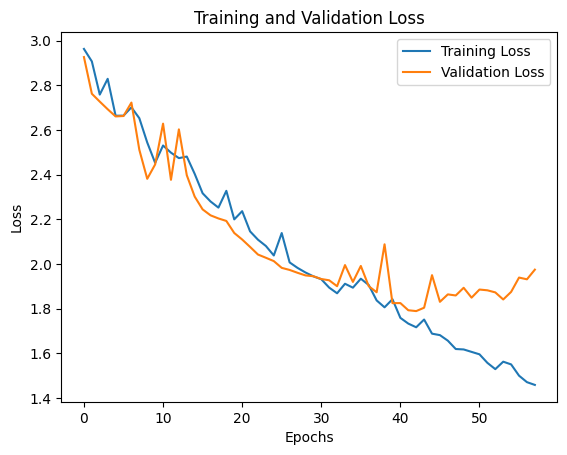

In [52]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

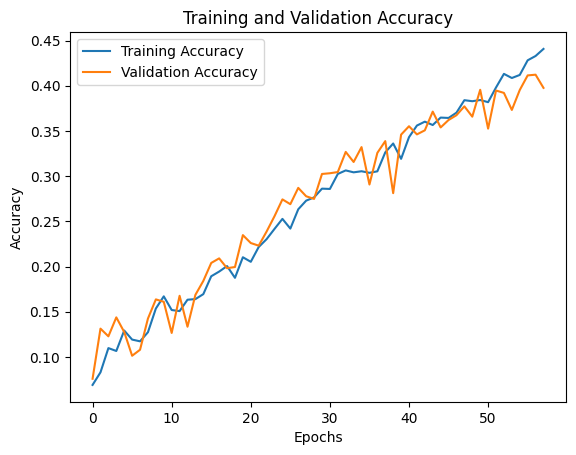

In [53]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [54]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3404 - loss: 1.8151
Test Loss: 1.7897024154663086
Test Accuracy: 0.35066312551498413
